## Construction of reference trajectory

### Step1. In this notebook, we will get the 2-dimensional embeddings of NaiveB and GCB cells within Mature TLS use [SPRING](https://github.com/AllonKleinLab/SPRING_dev)

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import sklearn.cluster
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csc_matrix
import scipy.io
import pickle
from scipy import sparse
from scipy.spatial.distance import pdist
from datetime import datetime
import json
import time
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_knn_graph(X, k=5, dist_metric='euclidean', approx=False, return_edges=True):
    '''
    Build k-nearest-neighbor graph
    Return edge list and nearest neighbor matrix
    '''

    t0 = time.time()
    if approx:
        try:
            from annoy import AnnoyIndex
        except:
            approx = False
            #print 'Could not find library "annoy" for approx. nearest neighbor search'
    if approx:
        #print 'Using approximate nearest neighbor search'

        if dist_metric == 'cosine':
            dist_metric = 'angular'
        npc = X.shape[1]
        ncell = X.shape[0]
        annoy_index = AnnoyIndex(npc, metric=dist_metric)

        for i in range(ncell):
            annoy_index.add_item(i, list(X[i,:]))
        annoy_index.build(10) # 10 trees

        knn = []
        for iCell in range(ncell):
            knn.append(annoy_index.get_nns_by_item(iCell, k + 1)[1:])
        knn = np.array(knn, dtype=int)

    else:
        #print 'Using sklearn NearestNeighbors'

        if dist_metric == 'cosine':
            nbrs = NearestNeighbors(n_neighbors=k, metric=dist_metric, algorithm='brute').fit(X)
        else:
            nbrs = NearestNeighbors(n_neighbors=k, metric=dist_metric).fit(X)
        knn = nbrs.kneighbors(return_distance=False)

    if return_edges:
        links = set([])
        for i in range(knn.shape[0]):
            for j in knn[i,:]:
                links.add(tuple(sorted((i,j))))

        t_elapse = time.time() - t0
        #print 'kNN graph built in %.3f sec' %(t_elapse)

        return links, knn
    return knn

def get_force_layout(links, n_cells, n_iter=100, edgeWeightInfluence=1, barnesHutTheta=2, scalingRatio=1, gravity=0.05, jitterTolerance=1, verbose=False):
    from fa2 import ForceAtlas2
    import networkx as nx

    G = nx.Graph()
    G.add_nodes_from(range(n_cells))
    G.add_edges_from(list(links))

    forceatlas2 = ForceAtlas2(
                  # Behavior alternatives
                  outboundAttractionDistribution=False,  # Dissuade hubs
                  linLogMode=False,  # NOT IMPLEMENTED
                  adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                  edgeWeightInfluence=edgeWeightInfluence,

                  # Performance
                  jitterTolerance=jitterTolerance,  # Tolerance
                  barnesHutOptimize=True,
                  barnesHutTheta=barnesHutTheta,
                  multiThreaded=False,  # NOT IMPLEMENTED

                  # Tuning
                  scalingRatio=scalingRatio,
                  strongGravityMode=False,
                  gravity=gravity,
                  # Log
                  verbose=verbose)

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=n_iter)
    positions = np.array([positions[i] for i in sorted(positions.keys())])
    return positions


In [3]:
save_path = '/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/2.spring'
os.chdir(save_path)
prefix = 'Harmony_Mature'
dist_metric = 'euclidean'
use_approxnn = False

In [4]:
# read the harmony embedding of GCB and Naive B cells within mature TLS
df_harmony = pd.read_csv('/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/1.data/harmony.rst.txt', index_col=0, sep='\t')
df_harmony

,harmony_1,harmony_2,harmony_3,harmony_4,harmony_5,harmony_6,harmony_7,harmony_8,harmony_9,harmony_10,...,harmony_41,harmony_42,harmony_43,harmony_44,harmony_45,harmony_46,harmony_47,harmony_48,harmony_49,harmony_50
ST2740P_BIN.136908,5.113925,-2.469733,-1.467572,-0.779979,-2.654942,-0.285961,2.077342,0.740907,0.116372,-0.718320,...,-1.095729,0.977224,1.666109,0.757487,0.445144,1.506884,1.244650,2.252660,0.467890,-0.617507
ST2740P_BIN.137428,3.054659,1.087155,0.190990,1.308317,1.909833,0.948894,-0.913072,0.589693,1.586337,1.692299,...,1.722779,0.166911,-0.286102,-0.306659,1.386201,1.660685,-0.615368,0.189916,-1.198564,0.699921
ST2740P_BIN.137429,2.019742,2.318382,0.571481,0.840274,1.235102,1.904423,-1.335633,0.015586,2.640070,-0.634110,...,0.073056,-0.862248,0.744453,0.441748,0.906242,0.830649,-0.031422,2.998638,1.026907,0.418784
ST2740P_BIN.137430,0.102157,1.761585,-0.440522,0.360328,0.426412,0.595407,-0.319028,0.680536,0.702201,1.171517,...,2.349815,-0.176345,-0.472800,-0.113232,0.600315,-0.092057,1.728545,1.113506,0.820269,-2.081466
ST2740P_BIN.137431,0.347835,2.421237,0.060148,0.295449,1.720599,2.898477,-0.313839,0.535635,1.821556,-0.664078,...,1.271101,1.873346,-0.289105,-2.814090,-0.017603,0.901791,-0.642633,-0.544286,2.178602,0.077136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST2976T_BIN.79751,-6.321782,-0.958890,-1.768178,-1.827449,1.435323,1.440613,-1.278934,0.501619,0.277289,-0.480294,...,-0.619037,1.406457,-0.492766,0.331463,0.153282,-0.387806,-0.384872,-0.752673,-1.287300,-2.037451
ST2976T_BIN.80279,-5.680288,-2.046921,0.185429,0.123319,1.931341,1.098448,-1.157804,-3.068455,0.500819,-0.983093,...,0.028344,-2.237765,-0.947990,1.520495,-1.167838,0.707359,-1.435366,0.932034,1.558347,0.875927
ST2976T_BIN.80280,-6.053382,-3.635056,-0.559709,-0.682826,2.648538,1.501292,-0.810827,0.002611,0.430116,-1.125924,...,0.792937,0.569191,-2.699297,-0.854452,1.322191,0.320778,-1.800819,-0.069448,1.606099,0.533409
ST2976T_BIN.80281,0.222804,2.035980,0.260820,-0.157755,1.577424,2.012824,-1.018597,0.660114,-0.124009,-0.370587,...,-0.382352,0.278143,-1.704177,0.923695,-1.065382,-0.502831,-0.769363,-0.590925,-0.464632,-0.779840


In [5]:
# read cell annotation result
df_anno = pd.read_csv('/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/1.data/Final.B_T.subAnnotation.txt', index_col=0, sep='\t')
df_anno = df_anno[df_anno['SubAnnotation'].isin(['B_Naive', 'B_GC'])][['sample', 'SubAnnotation']]
df_anno = df_anno.reindex(df_harmony.index)
df_anno

,sample,SubAnnotation
ST2740P_BIN.136908,ST2740P,B_Naive
ST2740P_BIN.137428,ST2740P,B_Naive
ST2740P_BIN.137429,ST2740P,B_Naive
ST2740P_BIN.137430,ST2740P,B_Naive
ST2740P_BIN.137431,ST2740P,B_GC
...,...,...
ST2976T_BIN.79751,ST2976T,B_GC
ST2976T_BIN.80279,ST2976T,B_GC
ST2976T_BIN.80280,ST2976T,B_GC
ST2976T_BIN.80281,ST2976T,B_GC


In [6]:
# construct knn graph and get links betwen cells
Epca = df_harmony.values

k_neigh = 21
links_pipeline, knn_graph_pipeline = get_knn_graph(Epca, k=k_neigh, dist_metric = dist_metric, approx=use_approxnn)

nbrs = NearestNeighbors(n_neighbors=min(df_harmony.shape[0]-1, 2000), metric=dist_metric).fit(Epca)
knn = nbrs.kneighbors(return_distance=False)
new_knn = []
for idx_target, infor in enumerate(knn):
    new_neighbor = []
    new_knn.append(infor[:k_neigh])

knn_graph = np.vstack(new_knn)

links = set([])
for i in range(knn_graph.shape[0]):
    for j in knn_graph[i,:]:
        links.add(tuple(sorted((i,j))))
print(list(links)[:3])

[(1509, 2584), (1237, 1896), (347, 607)]


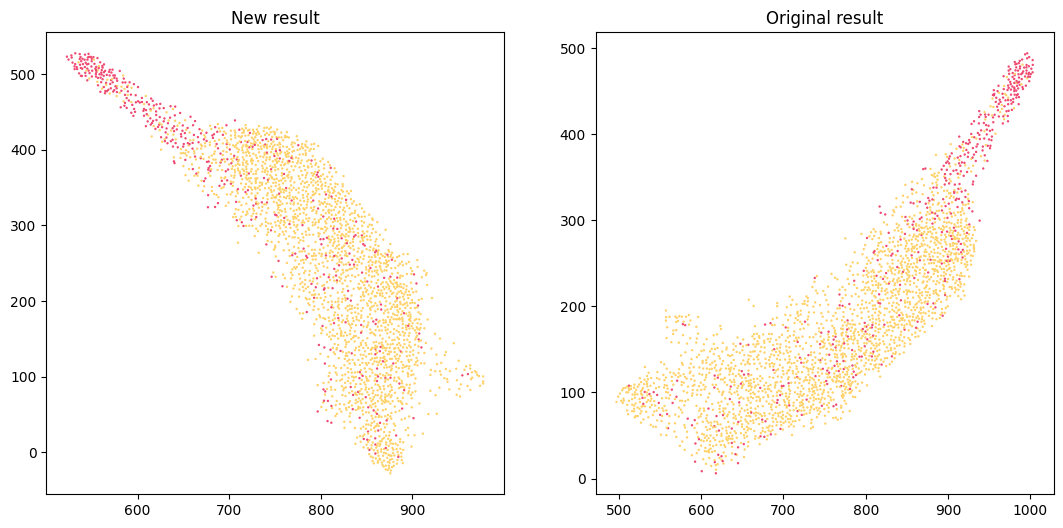

In [163]:
# Utilize ForceAtlas2 to visualize the KNN network in a two-dimensional coordinate system
num_force_iter = 1000
if num_force_iter > 0:
    positions = get_force_layout(links, Epca.shape[0], n_iter=num_force_iter,
        edgeWeightInfluence=1, barnesHutTheta=2, scalingRatio=1, gravity=0.05,
        jitterTolerance=1, verbose=False)
    positions = positions / 5.0
    positions = positions - np.min(positions, axis = 0) - np.ptp(positions, axis = 0) / 2.0
    positions[:,0] = positions[:,0]  + 750
    positions[:,1] = positions[:,1]  + 250

df_position = np.hstack((np.arange(positions.shape[0])[:,None], positions))
df_coor = pd.DataFrame(df_position[:, 1:3], index=df_anno.index, columns=['x', 'y'])

# plot
dic_anno = dict(zip(df_anno.index, df_anno['SubAnnotation']))
df_coor.index = df_harmony.index
df_coor['SubAnnotation'] = df_anno.index.map(dic_anno)

# the red dots represent the GCB cells while the yellow dots represent the naiveB cells
dic_color = {'B_GC': '#EF476F', 'B_Naive':'#FFD166'}
df_coor['color'] = df_coor['SubAnnotation'].map(dic_color)
fig, axes = plt.subplots(figsize=(13, 6), ncols=2, nrows=1)
ax1 = axes[0]
ax1.scatter(x=df_coor['x'], y=df_coor['y'], c=df_coor['color'], s=0.5)
ax1.set_title('New result')

# or you can use the results we has generated before
df_coor_raw = pd.read_csv('/data/yuchen_data/Stereo_seq/All_Figures/Tls_classification/1.data/Harmony_Mature.df_coor_k21.txt', index_col=0, sep='\t')
ax2 = axes[1]
ax2.scatter(x=df_coor_raw['x'], y=df_coor_raw['y'], c=df_coor_raw['color'], s=0.5)
ax2.set_title('Original result')
plt.show()